In [2]:
import random
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import math
from tensorflow.keras import Sequential, Model   # 按順序建立的神經網路
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, LSTM, TimeDistributed # Dense全連線層
from tensorflow.keras.layers import RepeatVector, Dense, Flatten, Input, Dropout, Conv1D, Lambda, GRU, Softmax, MaxPooling1D, multiply
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import datetime
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from keras import regularizers


In [3]:
import Dataset
#切train test
data = Dataset.Data_set('Training', 'X.csv', 'Y_level3_05s.csv')
#切train test
testdata = Dataset.Data_set('Testing','X.csv', 'Y_level3_05s.csv')
print(testdata.X_n_w.shape,testdata.Y.shape)

(878534, 18) (878534, 1)
被正規化後的形狀:  (878534, 18)
(207974, 18) (207974, 1)
被正規化後的形狀:  (207974, 18)
(207974, 3, 6) (207974, 1)


In [4]:
from  keras.utils import to_categorical
# zero-offset class values  從0開始計類
trainX = data.X_n_w
trainY = data.Y - 1
# one hot encode y
trainY = to_categorical(trainY)
print(trainX.shape, trainY.shape)

testX = testdata.X_n_w
testY = testdata.Y - 1
# one hot encode y
testY = to_categorical(testY)
print(testX.shape, testY.shape)

(878534, 3, 6) (878534, 3)
(207974, 3, 6) (207974, 3)


In [5]:
# confusion_matrix
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
 
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):   #plt.cm.Blues、plt.cm.bone_r
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize = (7, 7))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title,size=20)
    plt.colorbar(aspect=5)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=18)
    plt.yticks(tick_marks, classes, size=18)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)
    plt.tight_layout()

In [6]:
from tensorflow.keras.models import load_model
### 建模 EN-LSTM
start = time.time()

# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
sequence_autoencoder.summary()

trainX_decoded = sequence_autoencoder.predict(trainX,batch_size=128)  #
testX_decoded  = sequence_autoencoder.predict(testX,batch_size=128)

# LSTM
inputs = Input(shape=(3,6))
lstm1 = LSTM(64, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5)
             ,return_sequences=True)(inputs)
D1=Dropout(0.2)(lstm1)
lstm2 = LSTM(16, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5)
             ,return_sequences=False)(D1)
D2=Dropout(0.2)(lstm2)
regression_layers= Dense(3,activation='softmax')(D2)

model_L_D = Model(inputs, regression_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_L_D.compile(loss='categorical_crossentropy', optimizer=opt)
model_L_D.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history_L_D = model_L_D.fit(trainX_decoded, trainY, validation_split=0.1, 
                        epochs=100, batch_size=128, verbose=1,
                           callbacks=[early_stopping,tensorboard_callback])

# # 拿壓縮後的 testX丟進去測試準確度
# testX_encode_pred_L_E = model_L_E.predict(testX_bridge)

# testScore_L_E = math.sqrt(mean_squared_error(testY.reshape(-1,1), testX_encode_pred_L_E[:,0]))
# print('Test Score: %.2f RMSE' % (testScore_L_E))


testX_pred_L_D=model_L_D.predict(testX_decoded)#預測


end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 3)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 16)             1280      
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 32)             6272

[[52331 11801    69]
 [11198 58072  8552]
 [  373 15027 50551]]
              precision    recall  f1-score   support

           0     0.8189    0.8151    0.8170     64201
           1     0.6840    0.7462    0.7138     77822
           2     0.8543    0.7665    0.8080     65951

    accuracy                         0.7739    207974
   macro avg     0.7857    0.7759    0.7796    207974
weighted avg     0.7797    0.7739    0.7755    207974

Normalized confusion matrix
[[0.81511191 0.18381334 0.00107475]
 [0.14389247 0.74621572 0.1098918 ]
 [0.00565571 0.22785098 0.76649331]]
Confusion matrix, without normalization
[[52331 11801    69]
 [11198 58072  8552]
 [  373 15027 50551]]


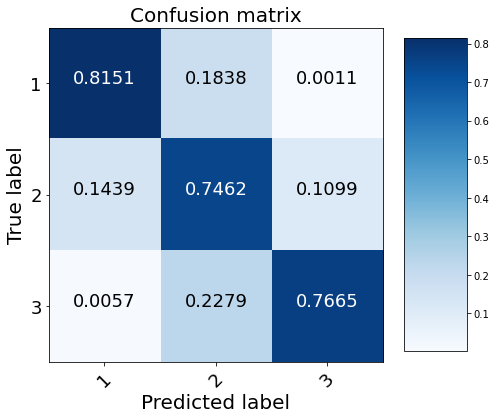

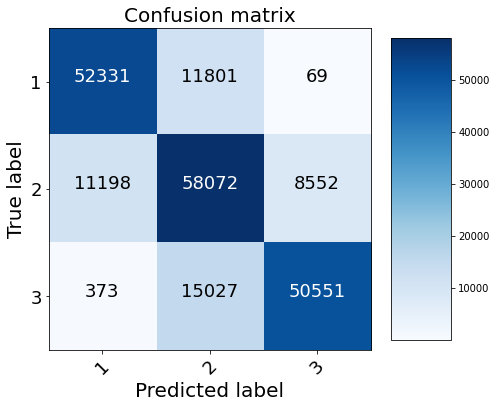

In [7]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred=np.argmax(testX_pred_L_D, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))
# 7731 7605 7651
y_pred=np.argmax(testX_pred_L_D, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)
class_names = ['1','2','3']
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names,normalize=False)

# DE_LSTM

In [ ]:
from tensorflow.keras.models import load_model
### 建模 EN-LSTM
start = time.time()




# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
sequence_autoencoder.summary()

trainX_decoded = sequence_autoencoder.predict(trainX,batch_size=128)  #
testX_decoded  = sequence_autoencoder.predict(testX,batch_size=128)


# LSTM
inputs = Input(shape=(3,6))
lstm1 = LSTM(64, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5)
             ,return_sequences=True)(inputs)
D1=Dropout(0.2)(lstm1)
lstm2 = LSTM(16, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5)
             ,return_sequences=False)(D1)
D2=Dropout(0.2)(lstm2)
regression_layers= Dense(3,activation='softmax')(D2)

model_L_D = Model(inputs, regression_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_L_D.compile(loss='categorical_crossentropy', optimizer=opt)
model_L_D.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

history_L_D = model_L_D.fit(trainX_decoded, trainY, validation_split=0.1, 
                        epochs=100, batch_size=128, verbose=1,
                           callbacks=[early_stopping,tensorboard_callback])

testX_pred_L_D=model_L_D.predict(testX_decoded)#預測


end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



In [ ]:
def plotLearningCurves(history):
    df = pd.DataFrame(history.history)
    df.plot(figsize=(13,10))  
    plt.legend(markerscale=1000, fontsize=20)
    plt.grid(True) # 顯示網格
    plt.xlabel('epoch', fontsize = 20)  
    plt.ylabel('loss', fontsize = 20) 
    plt.title('Train History')
    plt.gca().set_ylim(0.4, 1)   
    plt.show()
plotLearningCurves(history_L_D)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred=np.argmax(testX_pred_L_D, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))
# 7731 7605 7651

In [ ]:
y_pred=np.argmax(testX_pred_L_D, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)
class_names = ['1','2','3']
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names,normalize=False)

In [ ]:
# model_L_D.save('trained_model/model_L_D.h5')

# GRU

In [6]:
from tensorflow.keras.models import load_model
### 建模 EN-LSTM
start = time.time()

# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
sequence_autoencoder.summary()

trainX_decoded = sequence_autoencoder.predict(trainX,batch_size=128)  #
testX_decoded  = sequence_autoencoder.predict(testX,batch_size=128)

# 
inputs = Input(shape=(3,6))
lstm1 = GRU(64, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5)
             ,return_sequences=True)(inputs)
D1=Dropout(0.2)(lstm1)
lstm2 = GRU(16, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5)
             ,return_sequences=False)(D1)
D2=Dropout(0.2)(lstm2)
regression_layers= Dense(3,activation='softmax')(D2)

model_G_D = Model(inputs, regression_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_G_D.compile(loss='categorical_crossentropy', optimizer=opt)
model_G_D.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history_G_D = model_G_D.fit(trainX_decoded, trainY, validation_split=0.1, 
                        epochs=100, batch_size=128, verbose=1,
                           callbacks=[early_stopping,tensorboard_callback])

testX_pred_G_D=model_G_D.predict(testX_decoded)#預測


end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 3)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 16)             1280      
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 32)             6272

0.5124399662017822


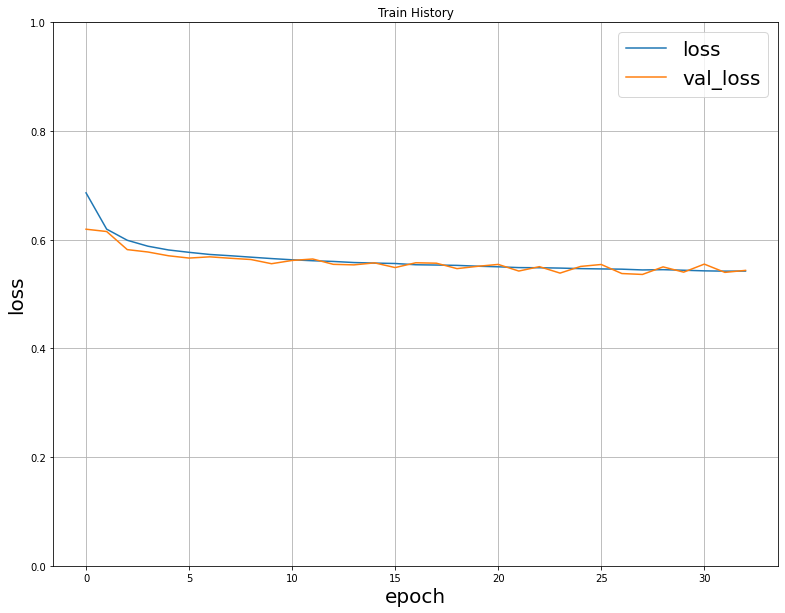

In [7]:
acc = model_G_D.evaluate(testX_decoded, testY, batch_size=128, verbose=0)
print(acc)
def plotLearningCurves(history):
    df = pd.DataFrame(history.history)
    df.plot(figsize=(13,10))  
    plt.legend(markerscale=1000, fontsize=20)
    plt.grid(True) # 顯示網格
    plt.xlabel('epoch', fontsize = 20)  
    plt.ylabel('loss', fontsize = 20) 
    plt.title('Train History')
    plt.gca().set_ylim(0, 1)   
    plt.show()
plotLearningCurves(history_G_D)

[[50930 13199    72]
 [10192 59138  8492]
 [  320 14754 50877]]
              precision    recall  f1-score   support

           0     0.8289    0.7933    0.8107     64201
           1     0.6790    0.7599    0.7172     77822
           2     0.8559    0.7714    0.8115     65951

    accuracy                         0.7739    207974
   macro avg     0.7880    0.7749    0.7798    207974
weighted avg     0.7814    0.7739    0.7760    207974

Normalized confusion matrix
[[0.79328982 0.2055887  0.00112148]
 [0.13096554 0.75991365 0.10912081]
 [0.00485209 0.22371154 0.77143637]]
Confusion matrix, without normalization
[[50930 13199    72]
 [10192 59138  8492]
 [  320 14754 50877]]


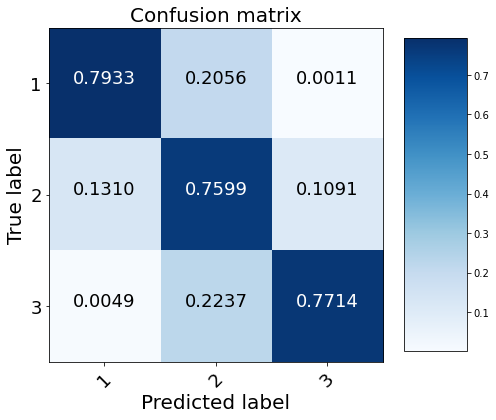

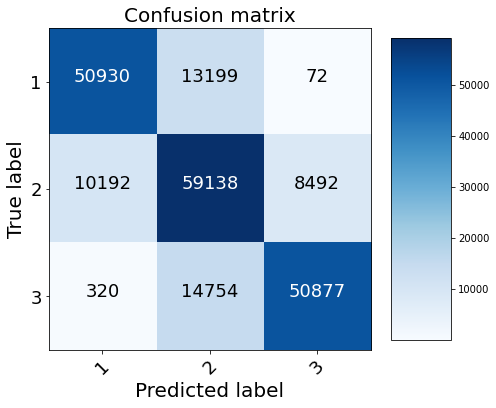

In [8]:
y_pred=np.argmax(testX_pred_G_D, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred, digits=4))
class_names = ['1','2','3']
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names,normalize=False)

# DE_RF

In [9]:
from tensorflow.keras.models import load_model
### 建模 EN-LSTM
start = time.time()

# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
sequence_autoencoder.summary()

trainX_decoded = sequence_autoencoder.predict(trainX,batch_size=128)  #
testX_decoded  = sequence_autoencoder.predict(testX,batch_size=128)

trainX_decoded_r = trainX_decoded.reshape(-1,18)
testX_decoded_r = testX_decoded.reshape(-1,18)

from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=100,n_jobs = -1,random_state =50, min_samples_leaf = 10)

# Y = data.trainY.reshape(-1)
history_RF = RF_model.fit(trainX_decoded_r,trainY )#,random_state=42

testX_pred_RF_D=RF_model.predict(testX_decoded_r)#預測

end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 3)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 16)             1280      
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 32)             6272

[[53440 10661   100]
 [11879 56961  8982]
 [ 1139 11935 52877]]
              precision    recall  f1-score   support

           0     0.8041    0.8324    0.8180     64201
           1     0.7160    0.7319    0.7239     77822
           2     0.8534    0.8018    0.8268     65951

    accuracy                         0.7851    207974
   macro avg     0.7912    0.7887    0.7896    207974
weighted avg     0.7868    0.7851    0.7856    207974

Normalized confusion matrix
[[0.83238579 0.1660566  0.00155761]
 [0.15264321 0.73193955 0.11541723]
 [0.0172704  0.18096769 0.80176191]]
Confusion matrix, without normalization
[[53440 10661   100]
 [11879 56961  8982]
 [ 1139 11935 52877]]


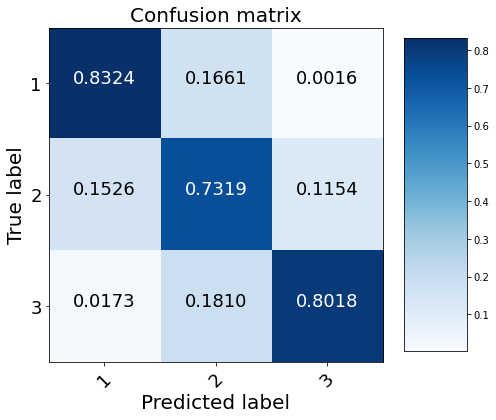

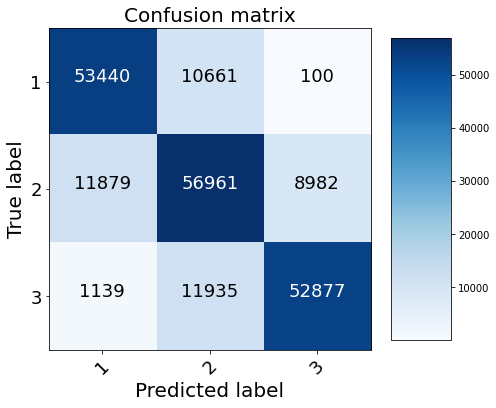

In [10]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred=np.argmax(testX_pred_RF_D, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))
class_names = ['1','2','3']
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names, normalize=False)

In [11]:
import joblib

joblib.dump(RF_model, 'trained_model/RF_model_fromDE')

['trained_model/RF_model_fromDE']

# DE_CNN

In [11]:
from tensorflow.keras.models import load_model
import datetime
### 建模 EN-LSTM
start = time.time()

# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
sequence_autoencoder.summary()


trainX_encoded = sequence_autoencoder.predict(trainX,batch_size=128)  #
testX_encoded  = sequence_autoencoder.predict(testX,batch_size=128)
# valX_encoded  = encoder.predict(valX,batch_size=128)
print(trainX_encoded.shape)

inputs = Input(shape=(3,6))

c1 = Conv1D(32,1 , activation="relu")(inputs)
c1 = Conv1D(8,1 , activation="relu")(c1)
p1 = MaxPooling1D(pool_size=2)(c1)

f = Flatten()(p1)
d = Dense(8, activation="relu")(f)
regression_layers = Dense(3, activation='softmax')(d)
CNN_model = Model(inputs, regression_layers)
CNN_model.compile(loss="categorical_crossentropy", optimizer="adam")
CNN_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history_C_E = CNN_model.fit(trainX_encoded, trainY, validation_split=0.1, 
                        epochs=100, batch_size=128, verbose=1,
                           callbacks=[early_stopping,tensorboard_callback])



end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 3)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 16)             1280      
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 32)             6272

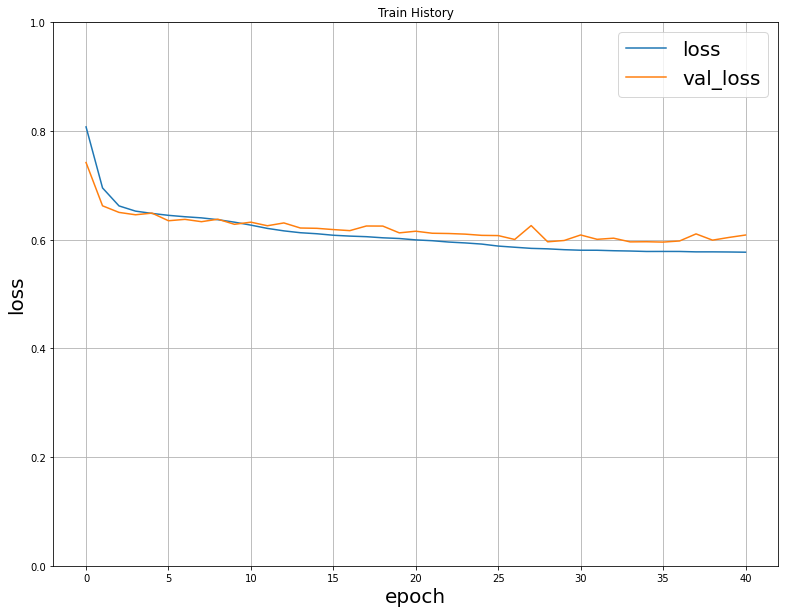

[[49316 14687   198]
 [11025 55374 11423]
 [  565 14419 50967]]
              precision    recall  f1-score   support

           0     0.8097    0.7682    0.7884     64201
           1     0.6555    0.7115    0.6824     77822
           2     0.8143    0.7728    0.7930     65951

    accuracy                         0.7484    207974
   macro avg     0.7598    0.7508    0.7546    207974
weighted avg     0.7535    0.7484    0.7502    207974

Normalized confusion matrix
[[0.76815003 0.22876591 0.00308406]
 [0.14166945 0.71154686 0.14678369]
 [0.00856697 0.21863201 0.77280102]]
Confusion matrix, without normalization
[[49316 14687   198]
 [11025 55374 11423]
 [  565 14419 50967]]


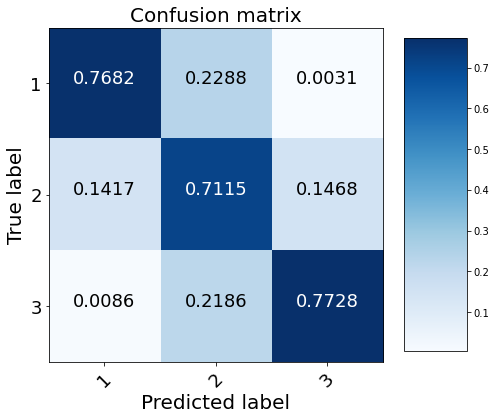

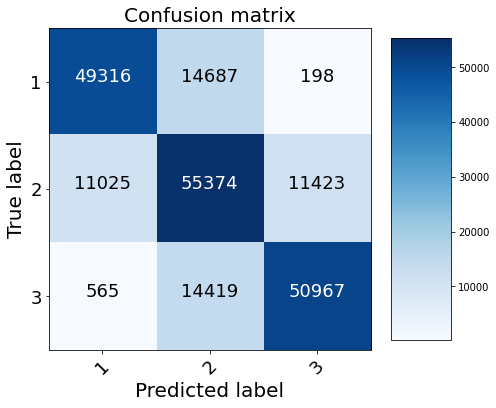

In [12]:
plotLearningCurves(history_C_E)

from sklearn.metrics import classification_report,confusion_matrix
testX_pred_C = CNN_model.predict(testX_encoded)

y_pred=np.argmax(testX_pred_C, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names, normalize=False)